In [1]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from skimage import feature
import numpy as np
import cv2
import math
from scipy import ndimage


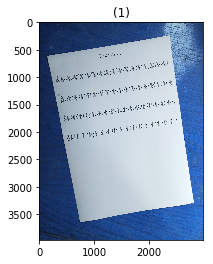

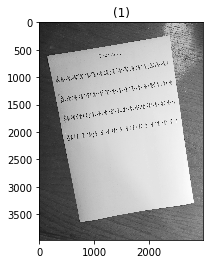

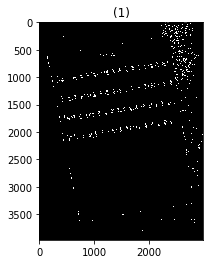

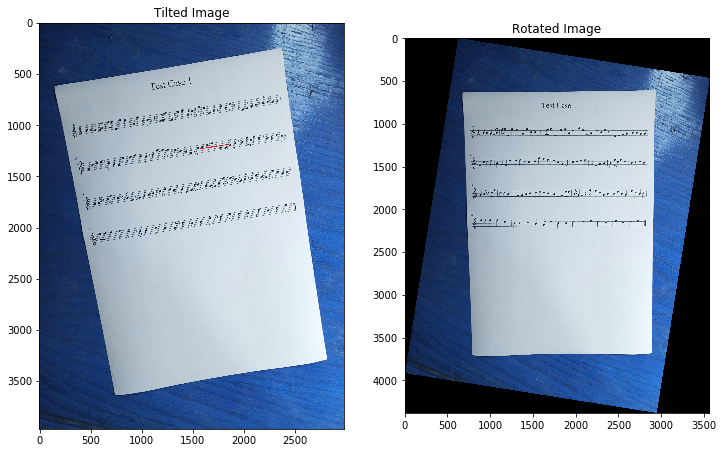

In [12]:
#rotation (samy's part)
img_before = cv2.imread('imgs/2.jpg')
show_images([img_before])
cv2.imshow("Before", img_before)    
img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
show_images([img_gray])
img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
show_images([img_edges])
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
angles = []

for x1, y1, x2, y2 in lines[0]:
    cv2.line(img_before, (x1, y1), (x2, y2), (255, 0, 0), 5)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

median_angle = np.median(angles)
img_rotated = ndimage.rotate(img_before, median_angle)

show_images([img_before,img_rotated],['Tilted Image','Rotated Image'])

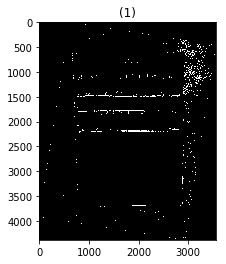

In [15]:
#cropping (kholy's part)
#work in img_rotated
#img.minval,maxval,kernel_size
img_edges = cv2.Canny(img_rotated, 50, 150, apertureSize=3)
show_images([img_edges])
cv2.imsave('imgs/2.jpg',)